In [15]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pickle
import torch
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      e
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.3.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [6]:
original_df = pd.read_csv('train.csv')
Y = original_df['label']
X = original_df.drop(['label'], axis=1)


0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [22]:
first_row = X.iloc[10].values
image_array = np.reshape(first_row, (28,28))
image_array



array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

## plot a randomn image for fun

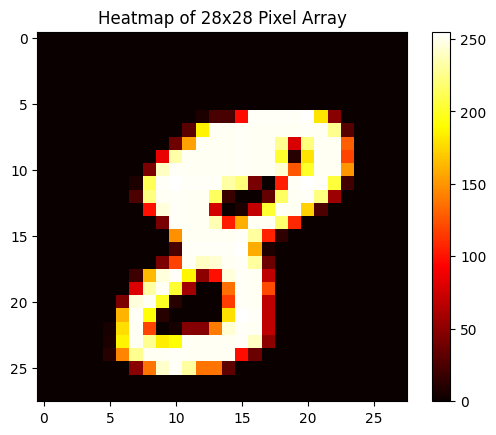

In [23]:
# Step 4: Display the numpy array as a heatmap
plt.imshow(image_array, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Heatmap of 28x28 Pixel Array")
plt.show()

## possibly we may want to make sure everything is equal to the number 5 to keep the dataset balanced, we will check back in on this later

In [26]:
from collections import defaultdict

counts = defaultdict(int)
for num in Y:
    counts[num] += 1
counts


defaultdict(int,
            {1: 4684,
             0: 4132,
             4: 4072,
             7: 4401,
             3: 4351,
             5: 3795,
             8: 4063,
             9: 4188,
             2: 4177,
             6: 4137})

## define netowrk

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #channel is 1 (no color, not RGB), outputs 32 convolutional features, 3 by 3 or  5 by 5 window
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        
        #-1, 1, 28, 28 is the shape of the tensor that we have
        x = torch.randn(28, 28).view(-1,1,28,28)
        
        self._to_linear = None
        
        self.convs(x)
        
        #getting the flattened data from the convolutional features
        self.fc1  = nn.Linear(self._to_linear, 100)
        self.f2  = nn.Linear(100, 10)
    # just like the forward method but onlyt running it through the conv lauers
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        #have to run this first to see the dimension that we are flattening the data to
        if self._to_linear is None:
            ##x[0] means the first element in the batch of data
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x 
    def forward(self, x):
        x = self.convs(x)
        #flatten data
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.f2(x)
        return F.softmax(x, dim=1)
net = Net()



In [92]:
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Normalize the input data
X = X / 255.0

X_train, X_test, y_train, y_test  = train_test_split(X, Y, test_size=0.1, shuffle=True)

tensor__train_X = torch.Tensor([X.iloc[i].values for i in range(len(X))])
X_train.head()


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
4261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Transfer to tensor object and move to GPU

In [93]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
##one hot encode them
y_train_ohe = enc.fit_transform(pd.DataFrame(y_train))
y_test_ohe = enc.fit_transform(pd.DataFrame(y_test))

y_train_ohe_df = pd.DataFrame.sparse.from_spmatrix(y_train_ohe)
y_test_ohe_df = pd.DataFrame.sparse.from_spmatrix(y_test_ohe)

In [94]:
def to_tensor(array):   
     tensor = torch.Tensor([array.iloc[i].values for i in range(len(array))])
     return tensor
X_train_tensor = to_tensor(X_train)
X_test_tensor = to_tensor(X_test)

Y_test_tensor = torch.Tensor(y_test_ohe_df.values)
Y_train_tensor = torch.Tensor(y_train_ohe_df.values)


## moving to to device

In [95]:
device = torch.device('mps')
net.to(device)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)
Y_test_tensor = Y_test_tensor.to(device)

## Training

In [157]:
BATCH_SIZE = 100
EPOCHS = 20
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()
def train():
    for epoch in range(EPOCHS):
        #split the data into batches of 100 elements
        for i in tqdm(range(0, len(X_train_tensor), BATCH_SIZE)):
            #print(i, i+BATCH_SIZE)
            batch_X = X_train_tensor[i:i+BATCH_SIZE].view(-1,1,28,28)
            batch_Y = Y_train_tensor[i:i+BATCH_SIZE]
            net.zero_grad()
            #send the batch through the network
            outputs = net(batch_X)
            #pass through the loss function
            loss = loss_function(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            torch.mps.empty_cache() 
        print(f"Epoch: {epoch}, Loss: {loss}")
        
train()

100%|██████████| 378/378 [00:05<00:00, 73.46it/s]


Epoch: 0, Loss: 0.0015740152448415756


100%|██████████| 378/378 [00:04<00:00, 92.72it/s]


Epoch: 1, Loss: 1.7710273823468015e-05


100%|██████████| 378/378 [00:03<00:00, 95.72it/s]


Epoch: 2, Loss: 0.0009602230275049806


100%|██████████| 378/378 [00:03<00:00, 95.01it/s]


Epoch: 3, Loss: 0.002074686111882329


100%|██████████| 378/378 [00:03<00:00, 96.48it/s]


Epoch: 4, Loss: 0.000701439450494945


100%|██████████| 378/378 [00:03<00:00, 95.87it/s]


Epoch: 5, Loss: 0.0005553727969527245


100%|██████████| 378/378 [00:03<00:00, 97.38it/s]


Epoch: 6, Loss: 5.83850996918045e-05


100%|██████████| 378/378 [00:03<00:00, 97.16it/s]


Epoch: 7, Loss: 0.00014066119911149144


100%|██████████| 378/378 [00:03<00:00, 94.87it/s]


Epoch: 8, Loss: 2.7787345970864408e-06


100%|██████████| 378/378 [00:03<00:00, 96.42it/s]


Epoch: 9, Loss: 0.0005467695300467312


100%|██████████| 378/378 [00:04<00:00, 93.49it/s]


Epoch: 10, Loss: 7.5341217780078296e-06


100%|██████████| 378/378 [00:04<00:00, 94.21it/s]


Epoch: 11, Loss: 0.0018272720044478774


100%|██████████| 378/378 [00:04<00:00, 92.19it/s]


Epoch: 12, Loss: 6.572144229721744e-06


100%|██████████| 378/378 [00:04<00:00, 94.05it/s]


Epoch: 13, Loss: 3.8014859455870464e-06


100%|██████████| 378/378 [00:04<00:00, 88.75it/s]


Epoch: 14, Loss: 6.9821837200834125e-09


100%|██████████| 378/378 [00:04<00:00, 90.37it/s]


Epoch: 15, Loss: 0.00012715371849481016


100%|██████████| 378/378 [00:03<00:00, 95.36it/s]


Epoch: 16, Loss: 1.233919544318951e-08


100%|██████████| 378/378 [00:04<00:00, 91.91it/s]


Epoch: 17, Loss: 0.00035278827999718487


100%|██████████| 378/378 [00:04<00:00, 94.25it/s]


Epoch: 18, Loss: 4.276986510376446e-05


100%|██████████| 378/378 [00:03<00:00, 95.84it/s]

Epoch: 19, Loss: 5.1250204705866054e-05


In [158]:
def test():
    correct = 0 
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(X_test_tensor))):
            real_class = torch.argmax(Y_test_tensor[i])
            net_out = net(X_test_tensor[i].view(-1,1,28,28))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct/total,3))
test()

100%|██████████| 4200/4200 [00:09<00:00, 459.92it/s]

Accuracy: 0.983


## Pretty good accuracy !!!! Now it's time to make predictions on the test.csv

In [101]:
test_df = pd.read_csv('test.csv')
test_df = test_df / 255.0


In [131]:
test_df_tensor = to_tensor(test_df)
test_df_tensor = test_df_tensor.to(device)


28000

In [150]:
def get_outputs():
    print("Hello")
    outputs = []
    with torch.no_grad():
        for i in tqdm(range(len(test_df_tensor))):
            net_out = net(test_df_tensor[i].view(-1,1,28,28))[0]
            predicted_class = torch.argmax(net_out).item()
            outputs.append(predicted_class)
        return outputs

In [151]:
outputs = get_outputs()

Hello


100%|██████████| 28000/28000 [00:57<00:00, 487.96it/s]


In [152]:
print(outputs[0:10])

[2, 0, 9, 9, 3, 7, 0, 3, 0, 3]


## a little bit of, cheating, but looking at some of the early outputs from training it looks like we are getting close

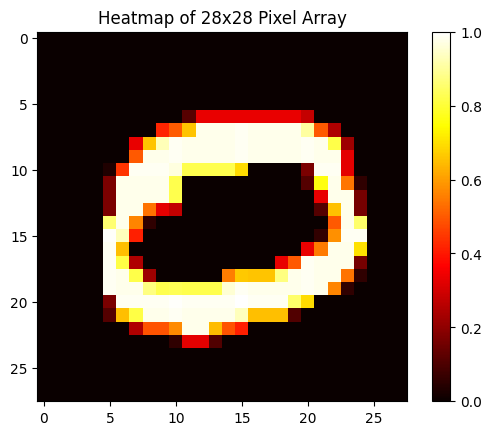

In [153]:
first_row = test_df.iloc[1].values
image_array = np.reshape(first_row, (28,28))
image_array
# Step 4: Display the numpy array as a heatmap
plt.imshow(image_array, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Heatmap of 28x28 Pixel Array")
plt.show()

In [156]:
# Zip predictions with their indices + 1
zipped_predictions = list(zip(range(1, len(outputs) + 1), outputs))

# Create DataFrame
df_predictions = pd.DataFrame(zipped_predictions, columns=['ImageId', 'Label'])
df_predictions.head()
df_predictions.to_csv('predictions.csv', index=False)